# Featue Constancy in iResNet

Test the imwarp_NCHW() function.

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
# > see: adopted from https://github.com/wyf2017/DSMnet/blob/master/utils/imwrap.py;
def imwarp_NCHW_V1(im_src, disp, fliplr=False, LeftTop=[0, 0], scale_factor=1):
    '''
    the shape of im_src should be (bn, c , h0, w0)
    the shape of disp should be (bn, 1 , h, w)
    fliplr is the flag of flip im_src horizontally
    LeftTop is the imwarp's left top position in im_src_fliplr
    scale_factor is rate of scale between imwarp and im_src
    '''
    # ima
    bn, _, h0, w0 = im_src.shape
    bn, c, h, w = disp.shape
    assert c == 1 and min(h, w, h0, w0)>1

    # ------------------------compute area(x, x1, y, y1)------------------------------
    x, y = LeftTop
    #NOTE: Comment added by CCJ:
    # use w0 - 1, becuase width_idx = 0, 1, ..., w0-1;
    # i.e., the larget width_idx is w0-1, not w0.
    # So basically the operation here is just normalization: via:
    # x_new = 2*x/x_max - 1 , to get the new range [-1, 1], such that x_new \in [-1, 1]
    x = x*2.0/(w0 - 1) - 1 # use (w0-1) because the boundary is the center of pixel
    y = y*2.0/(h0 - 1) - 1
    x1 = x + (w - 1)*scale_factor*2.0/(w0 - 1)
    y1 = y + (h - 1)*scale_factor*2.0/(h0 - 1)
    print ("[***]imwarp_BCHW_V1(): leftTop=(%f,%f), rightBottom=(%f, %f)" %(x, y, x1, y1))
    # ---------------------------create sample grid-------------------------------------
    # Comments added by CCJ:
    # For example: 
    #print(torch.linspace(3,10,5)) # start = 3, end = 10, number_of_points = 5
    # > tensor([ 3.0000,  4.7500,  6.5000,  8.2500, 10.0000])
    # type=torch.float
    # print(torch.linspace(-10,10,steps=6,dtype=type))
    # > tensor([-10.,  -6.,  -2.,   2.,   6.,  10.]
    row = torch.linspace(x, x1, w)# start: x, end: x1, number_of_points: w
    col = torch.linspace(y, y1, h)
    grid = torch.zeros(bn, h, w, 2)
    for n in range(bn):
        for i in range(h):
            grid[n, i, :, 0] = row
        for i in range(w):
            grid[n, :, i, 1] = col
    grid = Variable(grid, requires_grad=False).type_as(im_src)
    k = -1.0 if fliplr else 1

    grid[:, :, :, 0] = k*(grid[:, :, :, 0] - disp.squeeze(1)*2.0/(w0 - 1))
    #print grid.shape, type(grid), type(im_src)
    
    
    # NOTE: Comment added by CCJ:
    # > see: https://pytorch.org/docs/stable/torch.html#torch.rand;
    # torch.rand(*size, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False)
    #  Returns a tensor filled with random numbers from a uniform distribution on the interval [0, 1);
    #  The shape of the tensor is defined by the variable argument `size`.
    #  For example: 
    #  torch.rand(4)
    #  >>> tensor([ 0.5204,  0.2503,  0.3525,  0.5673])

    # ---------------------------sample image by grid-----------------------------------
    delt = 1e-8*(torch.rand(1)[0] + 0.1) # 
    
    # comments added by CCJ:
    # > see: https://pytorch.org/docs/stable/nn.functional.html#grid-sample
    # NOTE: torch.nn.functional.grid_sample(input, grid, mode='bilinear', padding_mode='zeros', align_corners=None)
    # `grid` specifies the sampling pixel locations normalized by 
    # the `input` spatial dimensions. Therefore, it should have most 
    # values in the range of [-1, 1]. For example, 
    # values x = -1, y = -1 is the left-top pixel of input, 
    # and values x = 1, y = 1 is the right-bottom pixel of input.
    # If `grid` has values outside the range of [-1, 1], the corresponding 
    # outputs are handled as defined by padding_mode (e.g., padding_mode="zeros", "border", "reflection");
    im_warp = F.grid_sample(im_src + delt, grid)
    print ('[***] return im_warp size : ', im_warp.shape)
    return im_warp

Add pfm read function below:

In [4]:
""" this file works well in Python2 & 3"""
import re
def readPFM(file): 
    from struct import unpack
    with open(file, "rb") as f:
            # Line 1: PF=>RGB (3 channels), Pf=>Greyscale (1 channel)
        type = f.readline().decode('latin-1')
        if "PF" in type:
            channels = 3
        elif "Pf" in type:
            channels = 1
        else:
            sys.exit(1)
        # Line 2: width height
        line = f.readline().decode('latin-1')
        width, height = re.findall('\d+', line)
        width = int(width)
        height = int(height)

            # Line 3: +ve number means big endian, negative means little endian
        line = f.readline().decode('latin-1')
        BigEndian = True
        if "-" in line:
            BigEndian = False
        # Slurp all binary data
        samples = width * height * channels;
        buffer = f.read(samples * 4)
        # Unpack floats with appropriate endianness
        if BigEndian:
            fmt = ">"
        else:
            fmt = "<"
        fmt = fmt + str(samples) + "f"
        img = unpack(fmt, buffer)
        img = np.reshape(img, (height, width))
        img = np.flipud(img).astype(np.float32)
    return img

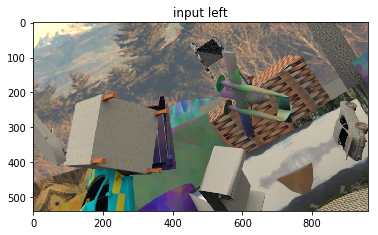

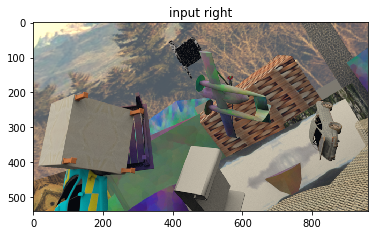

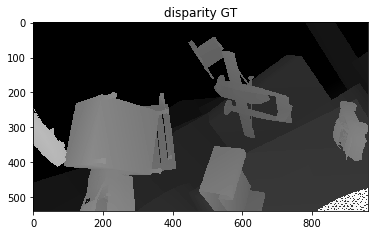

left, right, disp size:  (540, 960, 3) (540, 960, 3) (540, 960)


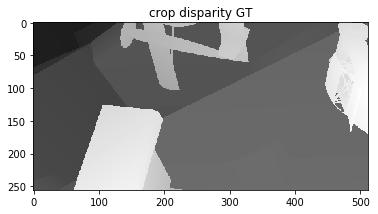

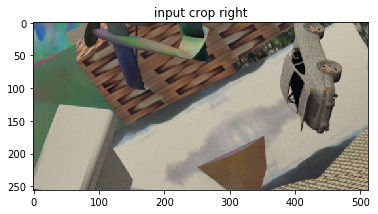

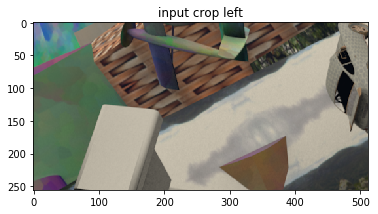

[???]imwarp_BCHW_V1 =  -1.0 1.0 -1.0 1.0
[???] return im_warp size :  torch.Size([1, 3, 256, 512])


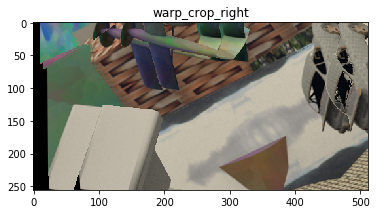

[!!!] left reconstruction error, i.e., left vs left_recons_warpped_from_right 17.603479385375977
[???]imwarp_BCHW_V1 =  -1.0 1.0 -1.0 1.0
[???] return im_warp size :  torch.Size([1, 3, 256, 512])


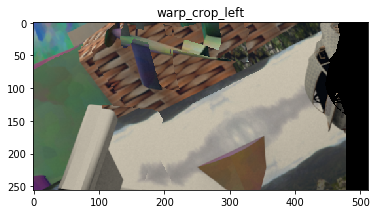

[!!!] right reconstruction error, i.e., right vs right_recons_warpped_from_left 34.31057357788086


In [27]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
def show(img, title = None):
    if title is not None:
        plt.title(title, loc='center')
    imgplot = plt.imshow(img.astype(np.float32), cmap='gray')
    plt.show()

def show_uint8(img, title = None):
    if title is not None:
        plt.title(title, loc='center')
    imgplot = plt.imshow(img.astype(np.uint8))
    plt.show()
    
disp_gt = readPFM('/media/ccj/ssd-1T-new/datasets/SceneFlowDataset/flyingthings3d/disparity/TRAIN/A/0000/left/0006.pfm')
filename = '/media/ccj/ssd-1T-new/datasets/SceneFlowDataset/flyingthings3d/frames_finalpass/TRAIN/A/0000/left/0006.png'
left = cv2.imread(filename)[:,:,::-1] # change BRG to RGB via `::-1`;

filename = '/media/ccj/ssd-1T-new/datasets/SceneFlowDataset/flyingthings3d/frames_finalpass/TRAIN/A/0000/right/0006.png'
right = cv2.imread(filename)[:,:,::-1] # change BRG to RGB via `::-1`;
show_uint8(left, title = 'input left')
show_uint8(right, title = 'input right')
show(disp_gt, title = 'disparity GT')
print ('left, right, disp size: ', left.shape, right.shape, disp_gt.shape)

h, w = disp_gt.shape[:]
crop_width = 512
crop_height = 256
start_x = random.randint(0, w - crop_width)
start_y = random.randint(0, h - crop_height)

crop_disp_gt = disp_gt[start_y: start_y + crop_height, start_x: start_x + crop_width]
crop_left = left[start_y: start_y + crop_height, start_x: start_x + crop_width,:]
crop_right = right[start_y: start_y + crop_height, start_x: start_x + crop_width,:]

show(crop_disp_gt, title = 'crop disparity GT')
show_uint8(crop_right, title = 'input crop right')
show_uint8(crop_left, title = 'input crop left')


# transpose
crop_left = crop_left.transpose((2,0,1)).astype(np.float32)
crop_right = crop_right.transpose((2,0,1)).astype(np.float32)
crop_left = torch.from_numpy(crop_left).float()[None, ...] # added batch dim
crop_right = torch.from_numpy(crop_right).float()[None, ...] # added batch dim
crop_disp_gt = torch.from_numpy(crop_disp_gt).float()[None, None, ...] # added batch and channel dims


warp_crop_right = imwarp_NCHW_V1(crop_right, crop_disp_gt)
show_uint8(warp_crop_right[0].numpy().transpose((1,2,0)), title = 'warp_crop_right')
res0 = torch.mean(torch.abs( warp_crop_right - crop_left))
print ("[!!!] left reconstruction error, i.e., left vs left_recons_warpped_from_right", res0.item())

warp_crop_left = imwarp_NCHW_V1(crop_left, -1*crop_disp_gt)
show_uint8(warp_crop_left[0].numpy().transpose((1,2,0)), title = 'warp_crop_left')
res1 = torch.mean(torch.abs( warp_crop_left - crop_right))
print ("[!!!] right reconstruction error, i.e., right vs right_recons_warpped_from_left", res1.item())

## Conclusion

`Note:` this warp function has been verified to be correct!!!